# Experiment 4
Code Overview :

+ select three features manually. description - title - price
+ FastText to get embedding of non numeric features
+ AutoEncoder for dimention reduction
+ upsampling and augmentation to solve unbalanced dataset problem


In [1]:
!pip install hazm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from hazm import Normalizer, sent_tokenize,word_tokenize,Lemmatizer,Stemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import datasets
import pandas as pd 
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  f1_score, accuracy_score, confusion_matrix
import codecs
import torch
from gensim.models.fasttext import FastText
import math


In [3]:
divar_df = pd.read_csv('divar_sample_10k.csv')

In [4]:
input_x = divar_df[np.setdiff1d(divar_df.columns, ['cat1'])]
output_y = divar_df['cat1']

## Preprocess non numeric features
+ Normalizing 
+ Remove Stopwords

In [5]:
normalizer = Normalizer()
stopwords = [normalizer.normalize(x.strip()) for x in codecs.open(
    'stopwords.txt', 'r', 'utf-8').readlines()]
stopwords.extend(['تماس', 'تلگرام', 'واتساپ', 'با سلام', 'سلام', 'فروش', 'فوری',
                 'قیمت', 'مقطوع', 'تخفیف', 'نو', 'در حد نو', 'خرید', 'اقساطی', 'تحویل', 'اقساط'])

In [6]:
for idx , sent in enumerate(input_x['desc']):
    sent = normalizer.normalize(sent)
    input_x['desc'][idx] = '  '.join([str(elem) for elem in [t for t in word_tokenize(sent) if t not in stopwords]])
    if idx % 1000 == 0:
      print(idx)

<ipython-input-6-f34843c4209b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_x['desc'][idx] = '  '.join([str(elem) for elem in [t for t in word_tokenize(sent) if t not in stopwords]])


0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [7]:
for idx , sent in enumerate(input_x['title']):
    sent = normalizer.normalize(sent)
    input_x['title'][idx] = '  '.join([str(elem) for elem in [t for t in word_tokenize(sent) if t not in stopwords]])
    if idx % 1000 == 0:
      print(idx)

<ipython-input-7-3e008e98ddc5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_x['title'][idx] = '  '.join([str(elem) for elem in [t for t in word_tokenize(sent) if t not in stopwords]])


0
1000
2000
3000
4000
5000
6000
7000
8000
9000


## FastText
+ Training fasttext model
+ Get embedding of each element

In [8]:
desc_list = list(input_x['desc'])
titles_list = list(input_x['title'])
desc_word_tokens = [word_tokenize(i) for i in desc_list]
title_word_tokens = [word_tokenize(i) for i in titles_list]

In [9]:
embedding_size = 300
window_size = 5
min_word = 5
down_sampling = 1e-2
 
desc_fast_Text_model = FastText(desc_word_tokens,
                      vector_size =embedding_size,
                      window=window_size,
                      min_count=min_word,
                      sample=down_sampling,
                      workers = 4,
                      sg=1,
                      epochs=50)

title_fast_Text_model = FastText(title_word_tokens,
                      vector_size =embedding_size,
                      window=window_size,
                      min_count=min_word,
                      sample=down_sampling,
                      workers = 4,
                      sg=1,
                      epochs=50)

In [10]:
all_desc_emb = []

for idx , sent in enumerate(input_x['desc']):
  counter = 0
  sent_emb = []
  if idx % 1000 == 0:
    print(idx)
  for token in word_tokenize(sent):
        try:
            token_fast_emb = desc_fast_Text_model.wv[token]
            sent_emb.append(token_fast_emb)
        except:
            counter+=1
  all_desc_emb.append(np.mean(sent_emb,axis=0))

0
1000


/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2000
3000
4000
5000
6000
7000
8000
9000


In [11]:
all_titles_emb = []

for idx , sent in enumerate(input_x['title']):
  counter = 0
  sent_emb = []
  if idx % 1000 == 0:
    print(idx)
  for token in word_tokenize(sent):
        try:
            token_fast_emb = title_fast_Text_model.wv[token]
            sent_emb.append(token_fast_emb)
        except:
            counter+=1

  all_titles_emb.append(np.mean(sent_emb,axis=0))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [12]:
for idx , emb in enumerate(all_desc_emb):
  if type(all_desc_emb[idx]) == np.float64:
     all_desc_emb[idx] = np.zeros(300)
for idx , emb in enumerate(all_titles_emb):
  if type(all_titles_emb[idx]) == np.float64:
     all_titles_emb[idx] = np.zeros(300)

In [13]:
desc_embeddings_df = pd.DataFrame(all_desc_emb)
title_embeddings_df = pd.DataFrame(all_titles_emb)

### Auto-Encoder for dimention reduction

source

https://www.analyticsvidhya.com/blog/2021/06/dimensionality-reduction-using-autoencoders-in-python/

In [14]:
import math
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError

In [15]:
class AutoEncoders(Model):

  def __init__(self, output_units):

    super().__init__()
    self.encoder = Sequential(
        [
          Dense(200, activation="relu"),
          Dense(200, activation="relu"),
          Dense(100, activation="relu")
        ]
    )

    self.decoder = Sequential(
        [
          Dense(200, activation="relu"),
          Dense(200, activation="relu"),
          Dense(output_units, activation="sigmoid")
        ]
    )

  def call(self, inputs):

    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded


In [16]:
desc_embeddings_df.columns = desc_embeddings_df.columns.astype(str)
desc_X_train, desc_X_test, desc_y_train, desc_y_test = train_test_split(desc_embeddings_df, output_y, test_size=0.25, random_state=16)
title_embeddings_df.columns = title_embeddings_df.columns.astype(str)
title_X_train, title_X_test, title_y_train, title_y_test = train_test_split(title_embeddings_df, output_y, test_size=0.25, random_state=16)

In [17]:
desc_auto_encoder = AutoEncoders(len(desc_X_train.columns))

desc_auto_encoder.compile(
    loss='mae',
    metrics=['mae'],
    optimizer='adam'
)

desc_history = desc_auto_encoder.fit(
    desc_X_train, 
    desc_X_train, 
    epochs=15, 
    batch_size=128, 
    validation_data=(desc_X_test, desc_X_test)
)

Epoch 1/15
59/59 [==============================] - 3s 18ms/step - loss: 0.1832 - mae: 0.1832 - val_loss: 0.1090 - val_mae: 0.1090
Epoch 2/15
59/59 [==============================] - 1s 21ms/step - loss: 0.1087 - mae: 0.1087 - val_loss: 0.1087 - val_mae: 0.1087
Epoch 3/15
59/59 [==============================] - 1s 21ms/step - loss: 0.1090 - mae: 0.1090 - val_loss: 0.1094 - val_mae: 0.1094
Epoch 4/15
59/59 [==============================] - 1s 23ms/step - loss: 0.1093 - mae: 0.1093 - val_loss: 0.1094 - val_mae: 0.1094
Epoch 5/15
59/59 [==============================] - 1s 15ms/step - loss: 0.1093 - mae: 0.1093 - val_loss: 0.1094 - val_mae: 0.1094
Epoch 6/15
59/59 [==============================] - 1s 12ms/step - loss: 0.1093 - mae: 0.1093 - val_loss: 0.1094 - val_mae: 0.1094
Epoch 7/15
59/59 [==============================] - 1s 11ms/step - loss: 0.1093 - mae: 0.1093 - val_loss: 0.1094 - val_mae: 0.1094
Epoch 8/15
59/59 [==============================] - 1s 12ms/step - loss: 0.1093 - m

In [18]:
encoder_layer = desc_auto_encoder.get_layer('sequential')
desc_reduced_df = pd.DataFrame(encoder_layer.predict(desc_embeddings_df))
desc_reduced_df = desc_reduced_df.add_prefix('feature_')

313/313 [==============================] - 1s 2ms/step


In [19]:
desc_reduced_df.to_csv('desc_reduced_df.csv')

In [17]:
title_auto_encoder = AutoEncoders(len(title_X_train.columns))

title_auto_encoder.compile(
    loss='mae',
    metrics=['mae'],
    optimizer='adam'
)

title_history = title_auto_encoder.fit(
    title_X_train, 
    title_X_train, 
    epochs=15, 
    batch_size=128, 
    validation_data=(title_X_test, title_X_test)
)

Epoch 1/15
59/59 [==============================] - 3s 25ms/step - loss: 0.1967 - mae: 0.1967 - val_loss: 0.1272 - val_mae: 0.1272
Epoch 2/15
59/59 [==============================] - 1s 23ms/step - loss: 0.1299 - mae: 0.1299 - val_loss: 0.1275 - val_mae: 0.1275
Epoch 3/15
59/59 [==============================] - 1s 23ms/step - loss: 0.1299 - mae: 0.1299 - val_loss: 0.1275 - val_mae: 0.1275
Epoch 4/15
59/59 [==============================] - 1s 23ms/step - loss: 0.1299 - mae: 0.1299 - val_loss: 0.1275 - val_mae: 0.1275
Epoch 5/15
59/59 [==============================] - 1s 19ms/step - loss: 0.1299 - mae: 0.1299 - val_loss: 0.1275 - val_mae: 0.1275
Epoch 6/15
59/59 [==============================] - 2s 26ms/step - loss: 0.1299 - mae: 0.1299 - val_loss: 0.1275 - val_mae: 0.1275
Epoch 7/15
59/59 [==============================] - 2s 31ms/step - loss: 0.1299 - mae: 0.1299 - val_loss: 0.1275 - val_mae: 0.1275
Epoch 8/15
59/59 [==============================] - 2s 27ms/step - loss: 0.1299 - m

In [18]:
encoder_layer = title_auto_encoder.get_layer('sequential')
title_reduced_df = pd.DataFrame(encoder_layer.predict(title_embeddings_df))
title_reduced_df = title_reduced_df.add_prefix('feature_')

313/313 [==============================] - 1s 2ms/step


In [ ]:
title_reduced_df.to_csv('title_reduced_df.csv')

In [19]:
desc_reduced_df = pd.read_csv('desc_reduced_df.csv')

## Standard Scaling Entire the dataframe

In [20]:
scalar = StandardScaler()
numeric_scaled_features = pd.DataFrame(scalar.fit_transform(input_x[['price']]) , columns=['price'])

In [21]:
scalar = StandardScaler()
desc_reduced_df = pd.DataFrame(scalar.fit_transform(desc_reduced_df.values) , columns=desc_reduced_df.columns , index=desc_reduced_df.index)

In [22]:
scalar = StandardScaler()
title_reduced_df = pd.DataFrame(scalar.fit_transform(title_reduced_df.values) , columns=title_reduced_df.columns , index=title_reduced_df.index)

In [23]:
title_reduced_df.columns = [i for i in range(100,200)]
title_reduced_df = title_reduced_df.add_prefix('feature_')

In [24]:
input_x = pd.concat([desc_reduced_df.iloc[: , 1:] , title_reduced_df , numeric_scaled_features], axis=1) 

In [25]:
input_x.columns = input_x.columns.astype(str)
X_train, X_test, y_train, y_test = train_test_split(input_x, output_y, test_size=0.25, random_state=16)

## Logistic Regression for classification




In [27]:
def conf_matrix(y_test, pred_test):    
    
    # Creating a confusion matrix
    con_mat = confusion_matrix(y_test, pred_test)
    con_mat = pd.DataFrame(con_mat, range(6), range(6))
   
    #Ploting the confusion matrix
    plt.figure(figsize=(6,6))
    sns.set(font_scale=1.5) 
    sns.heatmap(con_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)

In [29]:
logreg = LogisticRegression(random_state=16)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The f1 score for the testing data: 0.7212262302029061


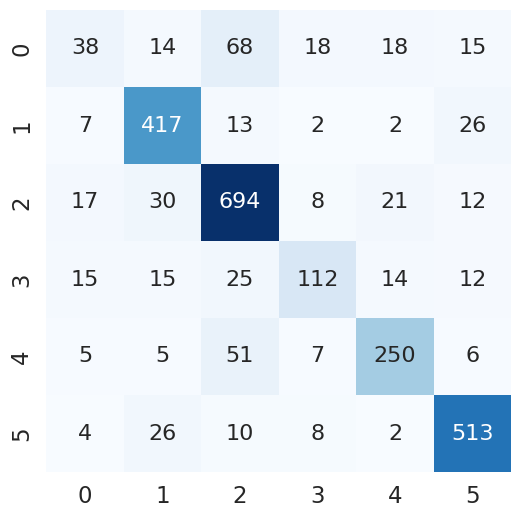

In [30]:
#Calculating and printing the f1 score 
f1_test = f1_score(y_test, y_pred , average='macro')
print('The f1 score for the testing data:', f1_test)

#Ploting the confusion matrix
conf_matrix(y_test, y_pred)

In [31]:
accuracy_score(y_test, y_pred)

0.8096

## plot unbalanced dataset

<Axes: xlabel='cat1', ylabel='Count'>

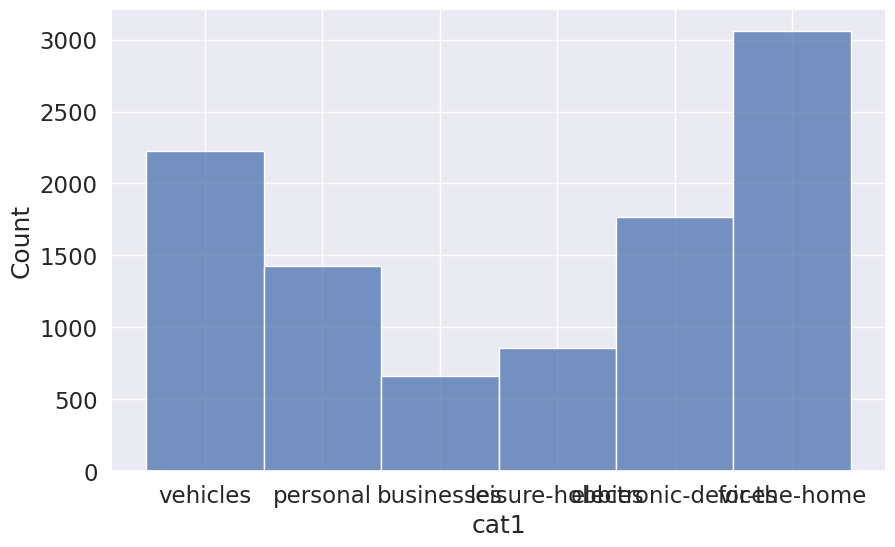

In [32]:
f, ax = plt.subplots(figsize=(10,6))
sns.histplot(data = output_y)

In [33]:
all_data_df = pd.concat([input_x ,output_y], axis=1) 

In [34]:
all_data_df.to_csv('fasttxt_without_aug_df.csv')

## Data Augmentation and upsampling

In [35]:
g = all_data_df.groupby('cat1')

categories_df = []

for k,v in g:
  categories_df.append(g.get_group(k).sample(g.size().max() , replace=True))

final_df = pd.concat(categories_df, axis=0).reset_index()

In [ ]:
final_df.to_csv('fasttxt_with_aug_df.csv')

In [36]:
input_x_final = final_df[np.setdiff1d(final_df.columns, ['cat1'])]
output_y_final = final_df['cat1']

<Axes: xlabel='cat1', ylabel='Count'>

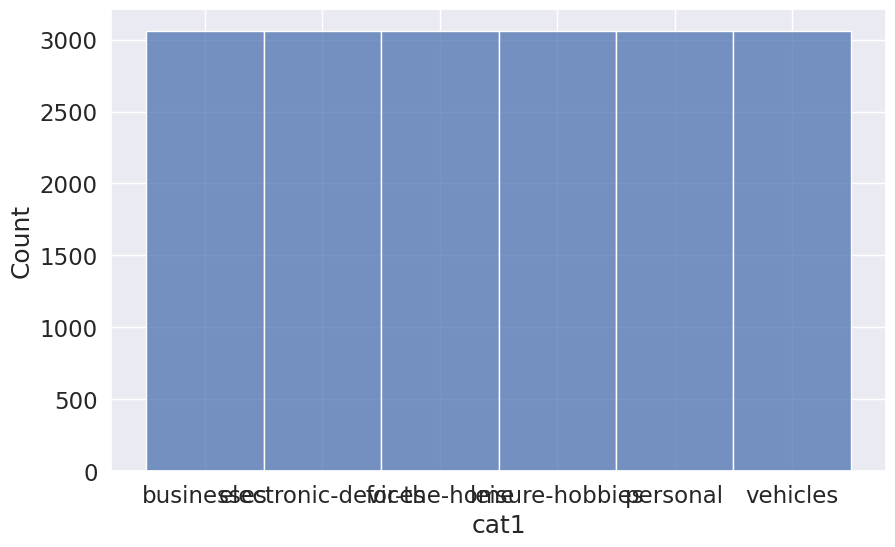

In [37]:
f, ax = plt.subplots(figsize=(10,6))
sns.histplot(data = output_y_final)

## check f1-score and accuracy with augmented data

In [38]:
input_x_final.columns = input_x_final.columns.astype(str)
X_train, X_test, y_train, y_test = train_test_split(input_x_final, output_y_final, test_size=0.25, random_state=16 , shuffle=True)

In [41]:
logreg = LogisticRegression(random_state=16)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The f1 score for the testing data: 0.42467034247056423


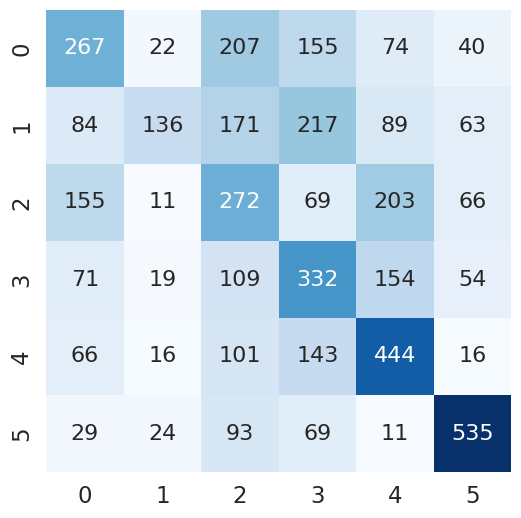

In [42]:
#Calculating and printing the f1 score 
f1_test = f1_score(y_test, y_pred , average='macro')
print('The f1 score for the testing data:', f1_test)

#Ploting the confusion matrix
conf_matrix(y_test, y_pred)

In [43]:
accuracy_score(y_test, y_pred)

0.4329627207325049